Команда "from sklearn.linear_model import LinearRegression", в составе:
Горбачев Алексей, БПИ163
Пепеляев Антон, БПИ163
Гатауллин Вадим, БПИ163

# Загружаем данные из Kaggle

In [3]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
%cd ~/.kaggle
from google.colab import files
files.upload()

/root/.kaggle


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lestrangge","key":"f35de243c9f6d3e48b10e0ed8bb76cae"}'}

In [4]:
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c postsold-prediction
!ls

cp: 'kaggle.json' and '/root/.kaggle/kaggle.json' are the same file
  0% 0.00/2.50M [00:00<?, ?B/s]
100% 2.50M/2.50M [00:00<00:00, 83.6MB/s]
 45% 9.00M/20.2M [00:00<00:00, 26.7MB/s]
100% 20.2M/20.2M [00:00<00:00, 51.0MB/s]
 79% 59.0M/74.7M [00:01<00:00, 37.5MB/s]
100% 74.7M/74.7M [00:01<00:00, 59.5MB/s]
kaggle.json  sample_submission.csv.zip	test_nolabel.tsv.gz  train.tsv.gz


# Зависимости

In [5]:
%pylab inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import gc

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords 

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Читаем

In [0]:
import pandas as pd
train = pd.read_csv('./data/train.tsv.gz', compression='gzip', index_col = 0, header=0, sep='\t', quotechar='"')
test = pd.read_csv('./data/test_nolabel.tsv.gz', compression='gzip', index_col = 0, header=0, sep='\t', quotechar='"')

In [7]:
train.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast
1,4,Краснодар,2018-10-08,False,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,True,500.0,8cb80c05c65c210275f5500779d6b593,1,"[{'slug_id': 'stoly_stulya_tip', 'slug_name': ...",Краснодарский край,1,410,1
2,4,Тюмень,2018-06-18,False,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,False,300.0,3b7a9f8b27a53b63525f95bc8070abb2,1,"[{'slug_id': 'dom_dacha_posuda_tip', 'slug_nam...",Тюменская область,1,405,0
4,9,Омск,2018-07-31,True,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,True,1100.0,c97dd9c5a3e938c52cf5d7822bc0eb7b,1,[{'slug_id': 'zhenskaya_odezhda_pidzhaki_kosty...,Омская область,1,908,0
6,3,Санкт-Петербург,2018-04-17,False,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,True,5000.0,3e5d0286b25fd7f62f88bc436a59ae4e,1,"[{'slug_id': 'waggon_type', 'slug_name': 'Тип'...",Ленинградская область,1,312,0
10,5,Москва,2018-02-09,False,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,True,2000.0,57b4a8679d0d3eb1e31367b57221098f,1,[],Московская область,1,504,0


# Парсим json

In [0]:
import json

def full_extract(x):
    try:
        slugs = json.loads(x.replace('"Colin\'s"',"'Colins'").replace('Carter\'s',"'Carters'").replace("\"O'Stin\"","'OStin'").replace("\"Victoria's Secret\"","'Victorias Secret'").replace("\"Levi's\"","'Levis'").replace("\\","").replace("\"Cee'd\"","'Ceed'").replace('"','').replace("'","\"") )
    except:
        print(x)
    
    result = ''
    for slug in slugs:
      result = slug['slug_name']+' '+slug['value']+' '
    
    return result

In [9]:
props = train[['properties']].fillna('[]').applymap(full_extract)
train['slugs']=props

props = test[['properties']].fillna('[]').applymap(full_extract)
test['slugs']=props

del props
gc.collect()

7

In [0]:
import json

def extract(x):
    try:
        slugs = json.loads(x.replace('"Colin\'s"',"'Colins'").replace('Carter\'s',"'Carters'").replace("\"O'Stin\"","'OStin'").replace("\"Victoria's Secret\"","'Victorias Secret'").replace("\"Levi's\"","'Levis'").replace("\\","").replace("\"Cee'd\"","'Ceed'").replace('"','').replace("'","\"") )
    except:
        print(x)
    
    slug_1 = 'NaN'
    slug_2 = 'NaN'
    slug_3 = 'NaN'

    if slugs[0:]:
        slug_1 = slugs[0]['value']
    
    if slugs[1:]:
        slug_2 = slugs[1]['value']

    if slugs[2:]:
        slug_3 = slugs[2]['value']
    
    return np.array([slug_1,slug_2,slug_3])

In [29]:
props = train[['properties']].fillna('[]').applymap(extract)
slugs_columns = pd.DataFrame(props.properties.values.tolist(), index= props.index,columns=['slug_1','slug_2','slug_3'])
train_slugs = pd.concat([train,slugs_columns],axis=1)

props = test[['properties']].fillna('[]').applymap(extract)
slugs_columns = pd.DataFrame(props.properties.values.tolist(), index= props.index,columns=['slug_1','slug_2','slug_3'])
test_slugs = pd.concat([test,slugs_columns],axis=1)

del props,slugs_columns
gc.collect()

14156

In [12]:
train_slugs.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast,slugs,slug_1,slug_2,slug_3
1,4,Краснодар,2018-10-08,False,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,True,500.0,8cb80c05c65c210275f5500779d6b593,1,"[{'slug_id': 'stoly_stulya_tip', 'slug_name': ...",Краснодарский край,1,410,1,Тип Столы,Столы,NaN,NaN
2,4,Тюмень,2018-06-18,False,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,False,300.0,3b7a9f8b27a53b63525f95bc8070abb2,1,"[{'slug_id': 'dom_dacha_posuda_tip', 'slug_nam...",Тюменская область,1,405,0,Тип Тарелки,Тарелки,NaN,NaN
4,9,Омск,2018-07-31,True,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,True,1100.0,c97dd9c5a3e938c52cf5d7822bc0eb7b,1,[{'slug_id': 'zhenskaya_odezhda_pidzhaki_kosty...,Омская область,1,908,0,Размер 46-48 (L),Костюмы с юбкой,46-48 (L),NaN
6,3,Санкт-Петербург,2018-04-17,False,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,True,5000.0,3e5d0286b25fd7f62f88bc436a59ae4e,1,"[{'slug_id': 'waggon_type', 'slug_name': 'Тип'...",Ленинградская область,1,312,0,Возраст До 3 лет,Прогулочная,До 3 лет,NaN
10,5,Москва,2018-02-09,False,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,True,2000.0,57b4a8679d0d3eb1e31367b57221098f,1,[],Московская область,1,504,0,,NaN,NaN,NaN


#Посмотрим на данные

##Построим матрицу корреляций

In [0]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

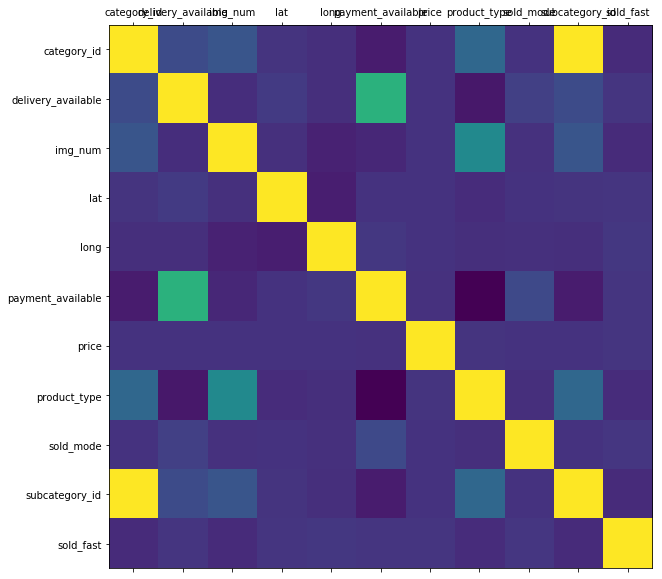

In [30]:
plot_corr(train_slugs)

In [17]:
train_slugs.corr()

,category_id,delivery_available,img_num,lat,long,payment_available,price,product_type,sold_mode,subcategory_id,sold_fast
category_id,1.000000,0.093396,0.134102,0.002093,-0.015816,-0.086009,-0.001442,0.219017,-0.002376,0.999796,-0.028493
delivery_available,0.093396,1.000000,-0.018591,0.027756,-0.015374,0.576631,-0.003085,-0.100231,0.046637,0.092702,0.005325
img_num,0.134102,-0.018591,1.000000,-0.012026,-0.060012,-0.041256,-0.001412,0.385218,-0.004169,0.133529,-0.030321
lat,0.002093,0.027756,-0.012026,1.000000,-0.074333,0.000139,-0.004076,-0.023136,-0.002864,0.002155,0.009313
long,-0.015816,-0.015374,-0.060012,-0.074333,1.000000,0.014551,-0.002286,-0.017147,-0.011267,-0.015897,0.015694
payment_available,-0.086009,0.576631,-0.041256,0.000139,0.014551,1.000000,-0.005349,-0.173822,0.085737,-0.086567,0.006845
price,-0.001442,-0.003085,-0.001412,-0.004076,-0.002286,-0.005349,1.000000,0.000712,-0.000451,-0.001457,0.006291
product_type,0.219017,-0.100231,0.385218,-0.023136,-0.017147,-0.173822,0.000712,1.000000,-0.014913,0.218327,-0.024471
sold_mode,-0.002376,0.046637,-0.004169,-0.002864,-0.011267,0.085737,-0.000451,-0.014913,1.000000,-0.002447,0.011726
subcategory_id,0.999796,0.092702,0.133529,0.002155,-0.015897,-0.086567,-0.001457,0.218327,-0.002447,1.000000,-0.028682


Заметим, что фичи слабо коррелируют сами по себе с таргетом, значит просто натравить какой-то алгоритм на данные и получить валидную модель не получится - придется предобработать фичи. Например, посчитать статистические фичи, предобработать тексты, провести кодирование категориальных фичей 
Кроме того, нет фичей, которые сильно коррелируют друг с другом, это хороший знак, что не придется выбрасывать фичи

Займемся этим

# Обрабатываем фичи

In [0]:
from sklearn import preprocessing

# Target and ID variables #
train_y = train_slugs["sold_fast"]
test_id = test_slugs["product_id"].values

# Label encode the categorical variables #
cat_vars = ["region", "city", "category_id", "subcategory_id", "slug_1", "slug_2", "slug_3"]
for col in cat_vars:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(set(list(train_slugs[col].values.astype('str')) + list(test_slugs[col].values.astype('str')))))
    train_slugs[col] = lbl.transform(list(train_slugs[col].values.astype('str')))
    test_slugs[col] = lbl.transform(list(test_slugs[col].values.astype('str')))

cols_to_drop = ["owner_id","product_id", "properties"]
train_X = train_slugs.drop(cols_to_drop + ["sold_fast"], axis=1)
test_X = test_slugs.drop(cols_to_drop, axis=1)

In [0]:
import datetime as dt


train_X['date_weekday'] = pd.to_datetime(train_X['date_created']).dt.weekday
train_X['date_day'] = pd.to_datetime(train_X['date_created']).dt.day
train_X['date_month'] = pd.to_datetime(train_X['date_created']).dt.month

test_X['date_weekday'] = pd.to_datetime(test_X['date_created']).dt.weekday
test_X['date_day'] = pd.to_datetime(test_X['date_created']).dt.day
test_X['date_month'] = pd.to_datetime(test_X['date_created']).dt.month

#train_X['date_created'] = (pd.to_datetime(train_X['date_created']) - dt.datetime(1970,1,1)).dt.days
#test_X['date_created'] = (pd.to_datetime(test_X['date_created']) - dt.datetime(1970,1,1)).dt.days

In [0]:
def fillna(df):
    df['sold_mode'].fillna(0,inplace=True)
    df['img_num'].fillna(0,inplace=True)
    df['lat'].fillna(0,inplace=True)
    df['long'].fillna(0,inplace=True)
    df['payment_available'].fillna(0,inplace=True)
    df['price'].fillna(df['price'].mean(),inplace=True)
    df['product_type'].fillna(-1,inplace=True)
    
    df['slugs'].fillna('',inplace=True)
    df['desc_text'].fillna('',inplace=True)
    df['name_text'].fillna('',inplace=True)

fillna(train_X)
fillna(test_X)

train_y.fillna(0,inplace=True)

In [22]:
train_X[train_X['price']<0]['price'] = 0
logged = np.log(train_X['price'])+1
logged[logged<0]=0
train_X['price']=logged

test_X[test_X['price']<0]['price'] = 0
logged = np.log(test_X['price'])+1
logged[logged<0]=0
test_X['price']=logged


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


# Добавляем статистические фичи

In [23]:
cols = ['category_id','city','subcategory_id','region','slug_1','slug_2','slug_3']

full_df = pd.concat([train_X,test_X],ignore_index=True)

for col in cols:
  print(col)

  stats = full_df.groupby(col)['price'].agg(['mean', 'max', 'min'])
  stats.columns = ['mean_'+col+'_price', 'max_'+col+'_price', 'min_'+col+'_price']
  train_X = train_X.merge(stats, left_on = col, right_index=True, how = 'left')
  test_X = test_X.merge(stats, left_on = col, right_index=True, how = 'left')

  def divide_two_cols(df_sub):
      df_sub[col+'_lots__count'] = full_df[full_df[col].isin(df_sub[col].unique())].shape[0]
      df_sub[col+'_relative_price'] = (df_sub['price'] / df_sub['mean_'+col+'_price']) * df_sub[col+'_lots__count']
      return df_sub

  train_X = train_X.groupby(col).apply(divide_two_cols)
  test_X = test_X.groupby(col).apply(divide_two_cols)

category_id
city
subcategory_id
region
slug_1
slug_2
slug_3


In [0]:
# cols =[ 
#     ['city','category_id'],
#     ['city','subcategory_id'],
#     ['region','category_id'],
#     ['region','subcategory_id'],
#     ['city','slug_1'],
#     ['region','slug_1']
# ]
# for col in cols:
#   print("_".join(col)) 
#   def sum_in_2cols(df):
    
#     #df["_".join(col)+'_lots_count'] = df.shape[0]
#     df["_".join(col)+'_mean_price'] = df['price'].mean()
#     #df["_".join(col)+'_relative_price'] = (df['price'] / df["_".join(col)+'_mean_price']) * df.shape[0]
#     return df

#   train_X = train_X.groupby(col).apply(sum_in_2cols)
#   test_X = test_X.groupby(col).apply(sum_in_2cols)


In [24]:
train_X.corr()

,category_id,city,delivery_available,img_num,lat,long,payment_available,price,product_type,region,sold_mode,subcategory_id,slug_1,slug_2,slug_3,date_weekday,date_day,date_month,mean_category_id_price,max_category_id_price,min_category_id_price,category_id_lots__count,category_id_relative_price,mean_city_price,max_city_price,min_city_price,city_lots__count,city_relative_price,mean_subcategory_id_price,max_subcategory_id_price,min_subcategory_id_price,subcategory_id_lots__count,subcategory_id_relative_price,mean_region_price,max_region_price,min_region_price,region_lots__count,region_relative_price,mean_slug_1_price,max_slug_1_price,min_slug_1_price,slug_1_lots__count,slug_1_relative_price,mean_slug_2_price,max_slug_2_price,min_slug_2_price,slug_2_lots__count,slug_2_relative_price,mean_slug_3_price,max_slug_3_price,min_slug_3_price,slug_3_lots__count,slug_3_relative_price
category_id,1.000000,0.001852,-0.123236,-0.028361,0.015331,-0.033054,-0.025913,-0.242723,0.037884,-0.000909,-0.023041,0.994270,0.104729,0.050308,0.085908,-0.000298,0.004565,0.054452,-0.440820,-0.518158,0.036185,0.274794,0.232486,-0.039227,0.013389,-0.019101,0.008250,-0.032260,-0.370231,-0.374550,0.010109,-0.246327,-0.243064,-0.042387,-0.000946,0.000090,0.003340,-0.050260,-0.301653,-0.030755,-0.144313,0.002186,-0.048691,-0.264950,0.047122,-0.136240,0.069496,-0.009205,-0.216067,-0.004036,-0.102331,0.027340,-0.070470
city,0.001852,1.000000,0.015775,-0.002149,0.141996,0.040648,0.006593,0.004061,-0.002880,0.352593,-0.003019,0.001230,0.001015,0.003180,0.003720,0.000071,0.000311,0.002840,0.000631,-0.005418,-0.002718,0.001404,0.003443,0.030399,0.011172,-0.017147,0.022735,0.021517,-0.000099,-0.002193,-0.003174,-0.000528,0.001233,0.066872,-0.092868,0.000203,-0.051666,-0.047855,-0.001109,-0.002202,-0.002501,-0.001844,-0.000332,-0.002504,-0.004261,-0.002111,-0.004047,-0.002206,-0.001558,-0.002037,-0.002276,-0.001717,-0.000133
delivery_available,-0.123236,0.015775,1.000000,-0.018591,0.027756,-0.015374,0.576631,0.168472,-0.100231,-0.001036,0.046637,-0.140934,-0.055578,0.018459,0.005459,-0.003326,-0.005590,0.016195,0.016052,-0.037422,-0.108519,0.175701,0.248434,-0.002525,0.101926,-0.074794,0.083446,0.114913,0.018860,0.010990,-0.137203,0.316437,0.339231,0.008734,0.030662,-0.005420,0.046356,0.086435,0.014499,-0.027815,-0.090213,-0.042056,0.011148,0.020409,-0.130322,-0.069866,-0.129440,-0.048896,-0.003118,-0.101411,-0.098887,-0.097937,0.002454
img_num,-0.028361,-0.002149,-0.018591,1.000000,-0.012026,-0.060012,-0.041256,0.339775,0.385218,-0.010080,-0.004169,-0.035346,-0.022595,0.006203,0.012306,-0.002629,0.001632,0.010956,0.393023,0.115382,0.416656,-0.126408,-0.042284,0.074066,0.053445,0.035345,0.064506,0.117831,0.392539,0.111272,0.491464,0.074464,0.087571,0.009586,0.055891,0.006612,0.069602,0.143490,0.397105,-0.059073,0.343644,-0.146856,-0.107886,0.420268,-0.146364,0.372157,-0.210818,-0.138188,0.443046,-0.192722,0.411251,-0.260273,-0.163561
lat,0.015331,0.141996,0.027756,-0.012026,1.000000,-0.074333,0.000139,-0.020845,-0.023136,0.107310,-0.002864,0.013331,0.012820,0.011639,0.007622,0.001540,0.001045,0.003978,-0.028317,-0.031671,-0.023680,0.014323,0.009225,-0.145507,0.046542,-0.060052,0.195902,0.184768,-0.031885,-0.034231,-0.023737,-0.014185,-0.012604,-0.282549,-0.121310,0.008205,0.160340,0.148723,-0.024031,-0.026467,-0.012749,-0.023073,-0.025978,-0.020444,-0.021782,-0.012996,-0.017801,-0.023465,-0.019686,-0.014458,-0.012292,-0.010244,-0.017460
long,-0.033054,0.040648,-0.015374,-0.060012,-0.074333,1.000000,0.014551,0.018807,-0.017147,0.131064,-0.011267,-0.031390,-0.021897,-0.011363,-0.006377,0.002938,-0.001591,0.014132,0.029392,0.029336,-0.016072,-0.006319,-0.002514,0.127322,-0.221471,-0.004519,-0.288481,-0.272064,0.037231,0.041980,-0.009006,0.029597,0.027796,0.247758,-0.354808,-0.001326,-0.392125,-0.364058,0.020623,0.039129,-0.006786,0.035739,0.038446,0.016655,0.021067,0.000182,0.017052,0.022343,0.012177,0.009942,-0.001548,0.006188,0.013638
payment_available,-0.025913,0.006593,0

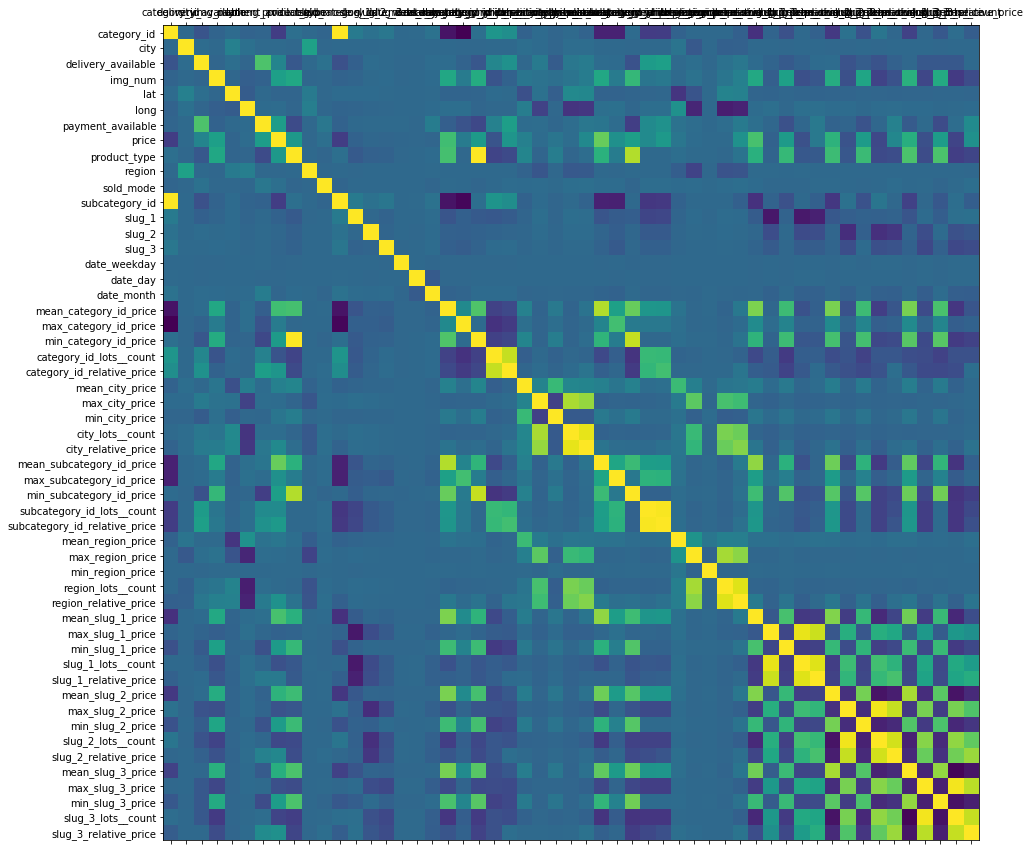

In [31]:
plot_corr(train_X, 15)

# Обрабатываем текст

## Препроцессинг
Очистим текстовые колонки от ненужных символов, добавим статистические фичи, посчитанные на текстах

In [0]:

russian_stop = set(stopwords.words('russian'))
len(russian_stop)

from sklearn.feature_extraction.text import TfidfVectorizer

text_cols = ['desc_text','name_text','slugs']

def clean(string):
    string = re.sub(r'\n', ' ', string)
    string = re.sub(r'\t', ' ', string)
    string = re.sub('[\W]', ' ', string)
    string = re.sub(r'\s{2,}', ' ', string.lower())
    return string

def process(df):
  for cols in text_cols:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].apply(clean)
    df[cols + '_num_chars'] = df[cols].apply(len) # Count number of Characters
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] # Count Unique Words
    df[cols + '_words_vs_unique'] = df[cols + '_words_vs_unique'].fillna(0)

process(train_X)
process(test_X)


print('processed')

del russian_stop 

processed


## CNN

Попробуем применить для решения задачи предобработки текстов сверточную нейронную сеть.



In [0]:
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, Add
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from sklearn.model_selection import KFold
import gc
import math
from sklearn import metrics

Using TensorFlow backend.


In [0]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ru.vec

--2019-06-13 22:57:34--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ru.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4954492872 (4.6G) [binary/octet-stream]
Saving to: ‘wiki.ru.vec’

wiki.ru.vec         100%[===================>]   4.61G  41.6MB/s    in 2m 1s   

2019-06-13 22:59:35 (39.0 MB/s) - ‘wiki.ru.vec’ saved [4954492872/4954492872]



In [0]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open('wiki.ru.vec'))

In [0]:
train_X['t'] = 0
train_X['d'] = 0
train_X['s'] = 0

test_X['t'] = 0
test_X['d'] = 0
test_X['s'] = 0

train_X['mix'] = 0
test_X['mix'] = 0

In [0]:
max_features =20000 #100000
maxlen = 100
embed_size = 300
filter_sizes = [1,2,3,4,3]
num_filters = 128 #32
batch_size = 256
epochs = 3

In [0]:
columns = ['name_text','desc_text','slugs']

inp = {}
test = {}

tokenizer = text.Tokenizer(num_words=max_features)

for col in columns:
  inp[col] = train_X[col].astype(str).fillna('fillna').values
  test[col] = test_X[col].astype(str).fillna('fillna').values
  
tokenizer.fit_on_texts(list([item for col in columns for item in inp[col]]) + list([item for col in columns for item in test[col]]))
print('tokenizer fitted')

for col in columns:
  inp[col] = tokenizer.texts_to_sequences(inp[col])
  test[col] = tokenizer.texts_to_sequences(test[col])
  
  inp[col] = sequence.pad_sequences(inp[col], maxlen=maxlen, padding='post')
  test[col] = sequence.pad_sequences(test[col], maxlen=maxlen, padding='post')
print('text tokenized')

tokenizer fitted
text tokenized


In [0]:
from keras.preprocessing import sequence
from keras.regularizers import l2
from keras.models import Model,Sequential
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dense, GlobalMaxPooling1D, Activation, Dropout, GaussianNoise, TimeDistributed
from keras.layers import Embedding, Input, BatchNormalization, SpatialDropout1D, Conv1D, LSTM,Bidirectional
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


kf = KFold(n_splits=2)
idtotal = kf.split(train_X)

def data_cleaning(ids):
    
    ret = {}
    
    for col in columns:
      ret[col+"_train"] = inp[col][ids[0]]
      ret[col+"_test"] = inp[col][ids[1]]

    y_train = train_y.iloc[ids[0]]
    ret['y_train'] = np.array(pd.concat([pd.Series(y_train),pd.Series(1-y_train)],axis=1))
    ret['y_test'] = train_y.iloc[ids[1]]
    
    print('data cleaned')

    return ret
  
  
  
def CNN(dic):
    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.zeros((nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    

    models = {}
    for col in columns:
      inp = Input(shape=(maxlen, ))
      x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
      x = SpatialDropout1D(0.3)(x)
      x = Reshape((maxlen, embed_size, 1))(x)
      
      maxpools = []
      for filt in filter_sizes:
        conv = Conv2D(num_filters, kernel_size=(filt, embed_size), kernel_initializer='normal', activation='elu')(x)
        maxpool = MaxPool2D(pool_size=(maxlen - filt + 1, 1))(conv)
        maxpools.append( maxpool )
        
      x = Concatenate(axis=1)(maxpools)   
      x = Flatten()(x)
      x = Dropout(0.2)(x)
      out = Dense(2, activation="softmax")(x)
      
      model = Model(inputs=[inp], outputs=out)
      model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
      models[col] = model
      
    print('CNN prepared')
    return models
  
def CNN(dic):
  
  word_index = tokenizer.word_index
  nb_words = min(max_features, len(word_index))
  embedding_matrix = np.zeros((nb_words, embed_size))
  for word, i in word_index.items():
      if i >= max_features: continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None: embedding_matrix[i] = embedding_vector
  
  
  models = {}
  for col in columns:
    inp = Input(shape=(maxlen,), dtype='int64')
    model = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)

    layers = []
    for i in range(3,7):
      x = Conv1D(filters=num_filters, kernel_size=i)(model)
      x = BatchNormalization()(x)
      x = Dropout(0.2)(x)
      x = Activation('relu')(x)
      x = GlobalMaxPooling1D()(x)
      layers.append(x)

    model = concatenate(layers, axis=1)
    model = Dropout(0.2)(model)

    model = Dense(32, activation='relu')(model)
    model = BatchNormalization()(model)
    model = Dropout(0.2)(model)

    out = Dense(2, activation='sigmoid')(model)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])
    models[col] = model
  
  return models

k = 0
test_results = {}
for ids in idtotal:
    k += 1
    print('Fold ' + str(k) + ' Start!')
    
    a = data_cleaning(ids)
    models = CNN(a)
     
      
    for col in columns:
      print(col+' training started')
      
      clsf = models[col].fit(a[col+"_train"], a['y_train'], batch_size=batch_size, epochs=3, verbose=2)
      results = models[col].predict(a[col+"_test"], batch_size=1024)
      
      train_X.loc[train_X.index[ids[1]],col+'_meta'] = results[:,0]
      test_res = pd.Series(models[col].predict(test[col], batch_size=1024)[:,0])

      if k == 1:
          test_results[col] = test_res
      else:
          test_results[col] += test_res
          
      print(col+' RMSE: %f' % math.sqrt(metrics.mean_squared_error(a['y_test'], results[:,0])))
  
for col in columns:
  test_results[col] = test_results[col]/2
  
print('Finish!')  

Fold 1 Start!
data cleaned


W0613 23:10:47.713712 140425570916224 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0613 23:10:48.168316 140425570916224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



name_text training started
Epoch 1/3
 - 54s - loss: 0.1929 - acc: 0.7445
Epoch 2/3
 - 50s - loss: 0.1747 - acc: 0.7674
Epoch 3/3
 - 50s - loss: 0.1680 - acc: 0.7694
name_text RMSE: 0.418984
desc_text training started
Epoch 1/3
 - 52s - loss: 0.1913 - acc: 0.7466
Epoch 2/3
 - 50s - loss: 0.1716 - acc: 0.7687
Epoch 3/3
 - 50s - loss: 0.1602 - acc: 0.7771
desc_text RMSE: 0.420678
slugs training started
Epoch 1/3
 - 52s - loss: 0.1932 - acc: 0.7520
Epoch 2/3
 - 50s - loss: 0.1770 - acc: 0.7687
Epoch 3/3
 - 50s - loss: 0.1760 - acc: 0.7687
slugs RMSE: 0.418786
Fold 2 Start!
data cleaned
name_text training started
Epoch 1/3
 - 53s - loss: 0.1939 - acc: 0.7411
Epoch 2/3
 - 50s - loss: 0.1739 - acc: 0.7686
Epoch 3/3
 - 50s - loss: 0.1675 - acc: 0.7705
name_text RMSE: 0.420138
desc_text training started
Epoch 1/3
 - 54s - loss: 0.1942 - acc: 0.7361
Epoch 2/3
 - 50s - loss: 0.1730 - acc: 0.7693
Epoch 3/3
 - 50s - loss: 0.1630 - acc: 0.7750
desc_text RMSE: 0.420148
slugs training started
Epoch 1/

In [0]:
tokenizer = text.Tokenizer(num_words=max_features)

input_t = train_X['name_text'].fillna('fillna').values
input_d = train_X['desc_text'].astype(str).fillna('fillna').values
input_s = train_X['slugs'].astype(str).fillna('fillna').values

test_t = test_X['name_text'].fillna('fillna').values
test_d = test_X['desc_text'].astype(str).fillna('fillna').values
test_s = test_X['slugs'].astype(str).fillna('fillna').values

tokenizer.fit_on_texts(list(input_t) + list(test_t))
tokenizer.fit_on_texts(list(input_d) + list(test_d))
tokenizer.fit_on_texts(list(input_s) + list(test_s))

input_t = tokenizer.texts_to_sequences(input_t)
test_t = tokenizer.texts_to_sequences(test_t)

input_d = tokenizer.texts_to_sequences(input_d)
test_d = tokenizer.texts_to_sequences(test_d)

input_s = tokenizer.texts_to_sequences(input_s)
test_s = tokenizer.texts_to_sequences(test_s)


input_t = sequence.pad_sequences(input_t, maxlen=maxlen_t)
test_t = sequence.pad_sequences(test_t, maxlen=maxlen_t)

input_d = sequence.pad_sequences(input_d, maxlen=maxlen_d)
test_d = sequence.pad_sequences(test_d, maxlen=maxlen_d)

input_s = sequence.pad_sequences(input_s, maxlen=maxlen_s)
test_s = sequence.pad_sequences(test_s, maxlen=maxlen_s)

In [0]:
def data_cleaning(ids):
    
    t_train = input_t[ids[0]]
    t_test = input_t[ids[1]]
    
    d_train = input_d[ids[0]]
    d_test = input_d[ids[1]]
    
    s_train = input_s[ids[0]]
    s_test = input_s[ids[1]]
    
    y_train_ = train_y.iloc[ids[0]]
    y_train_ = np.array(pd.concat([pd.Series(y_train_),pd.Series(1-y_train_)],axis=1))
    y_test_ = train_y.iloc[ids[1]]
        
    return {'x_train_t': t_train, 'x_test_t': t_test,'x_train_s': s_train, 'x_test_s': s_test, 'x_train_d': d_train,
           'x_test_d': d_test, 'y_train': y_train_, 'y_test': y_test_ }

In [0]:
k = 0
idtotal = kf.split(train_X)
for ids in idtotal:
    k += 1
    print('Fold ' + str(k) + ' Start!')
    
    print('Data Cleaning Start!')
    a = data_cleaning(ids)
    
    print('CNN Construction Start!')
    models = CNN(a)
  
    print('Title Trainning Start!')
    hist_t = models['t'].fit(a['x_train_t'], a['y_train'], batch_size=batch_size, epochs=3, verbose=2)

    valid_t_pred = models['t'].predict(a['x_test_t'], batch_size=1024)
    train_X.loc[train_X.index[ids[1]],'t'] = valid_t_pred[:,0]
    test_t_pred = pd.Series(models['t'].predict(test_t, batch_size=1024)[:,0])

    if k == 1:
        result_t = test_t_pred
    else:
        result_t += test_t_pred
    print('Title RMSE: %f' % math.sqrt(metrics.mean_squared_error(a['y_test'], valid_t_pred[:,0])))
    
    print('Description Trainning Start!')
    hist_d = models['d'].fit(a['x_train_d'], a['y_train'], batch_size=batch_size, epochs=3, verbose=2)
    valid_d_pred = models['d'].predict(a['x_test_d'], batch_size=1024)
    train_X.loc[train_X.index[ids[1]],'d'] = valid_d_pred[:,0]
    test_d_pred = pd.Series(models['d'].predict(test_d, batch_size=1024)[:,0])
    if k == 1:
        result_d = test_d_pred
    else:
        result_d += test_d_pred
        
    print('Description RMSE: %f' % math.sqrt(metrics.mean_squared_error(a['y_test'], valid_d_pred[:,0])))
    
    print('Slugs Trainning Start!')
    hist_s = models['s'].fit(a['x_train_s'], a['y_train'], batch_size=batch_size, epochs=3, verbose=2)
    valid_s_pred = models['s'].predict(a['x_test_s'], batch_size=1024)
    train_X.loc[train_X.index[ids[1]],'s'] = valid_d_pred[:,0]
    test_s_pred = pd.Series(models['s'].predict(test_s, batch_size=1024)[:,0])
    if k == 1:
        result_s = test_s_pred
    else:
        result_s += test_s_pred
        
    print('Slugs RMSE: %f' % math.sqrt(metrics.mean_squared_error(a['y_test'], valid_s_pred[:,0])))

result_t = result_t/3
result_d = result_d/3
result_s = result_s/3

print('Finish!')

Fold 1 Start!
Data Cleaning Start!
CNN Construction Start!
Title Trainning Start!
Epoch 1/3
 - 45s - loss: 0.1765 - mean_squared_error: 0.1765
Epoch 2/3
 - 43s - loss: 0.1718 - mean_squared_error: 0.1718
Epoch 3/3
 - 43s - loss: 0.1670 - mean_squared_error: 0.1670
Title RMSE: 0.420178
Description Trainning Start!
Epoch 1/3


KeyboardInterrupt: ignored

In [0]:
train_X['mix'] = train_X['s'] + train_X['d'] + train_X['t']
lol = pd.DataFrame({'t':test_results['name_text'],'d':test_results['desc_text'],'s': test_results['slugs'],'mix':test_results['desc_text']+test_results['name_text']+test_results['slugs']})
lol.index = test_X.index
test_X[['t','d','s','mix']] = lol
del lol
gc.collect()

1733

In [0]:
test_X.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,payment_available,price,product_type,region,sold_mode,subcategory_id,slugs,slug_1,slug_2,slug_3,date_weekday,date_day,date_month,mean_category_id_price,max_category_id_price,min_category_id_price,category_id_lots__count,category_id_relative_price,mean_city_price,max_city_price,min_city_price,city_lots__count,city_relative_price,mean_subcategory_id_price,max_subcategory_id_price,min_subcategory_id_price,subcategory_id_lots__count,subcategory_id_relative_price,mean_region_price,max_region_price,min_region_price,region_lots__count,region_relative_price,mean_slug_1_price,max_slug_1_price,min_slug_1_price,slug_1_lots__count,slug_1_relative_price,mean_slug_2_price,max_slug_2_price,min_slug_2_price,slug_2_lots__count,slug_2_relative_price,mean_slug_3_price,max_slug_3_price,min_slug_3_price,slug_3_lots__count,slug_3_relative_price,desc_text_num_chars,desc_text_num_words,desc_text_num_unique_words,desc_text_words_vs_unique,name_text_num_chars,name_text_num_words,name_text_num_unique_words,name_text_words_vs_unique,slugs_num_chars,slugs_num_words,slugs_num_unique_words,slugs_words_vs_unique,t,d,s,mix
0,23,2233,2018-10-22,True,ботильоны канадские 34 размер 35 но маломерят ...,3,55.2639,61.3972,ботильоны,True,7.476972,1,102,1,268,размер 35,2650,1848,692,0,22,10,7.254652,13.765688,0.0,53963,55616.706448,7.925966,16.068274,0.0,8801,8302.437251,7.319332,11.518673,0.0,11172,11412.617893,7.982831,16.068274,0.0,12245,11469.054390,7.990000,12.461632,0.0,864,808.523672,7.369005,9.853665,0.0,112,113.640973,7.407588,11.085809,0.0,152,153.423741,108,15,15,1.000000,9,1,1,1.0,10,2,2,1.0,0.195186,0.102892,0.178943,0.477022
3,13,137,2018-11-09,True,зимний костюм куртка в отличном состоянии на ш...,2,53.3426,83.7380,зимний костюм,True,7.620073,1,2,1,150,цвет фиолетовый,2066,1005,1898,4,9,11,6.592821,15.731801,0.0,39254,45370.313089,7.868188,18.322068,0.0,4840,4687.375786,7.373657,10.998798,0.0,10096,10433.392972,7.913385,18.322068,0.0,6445,6206.114303,6.627232,15.731801,0.0,4411,5071.822001,6.911801,9.853665,0.0,474,522.572142,7.410524,10.903488,0.0,1274,1310.025147,179,28,24,0.857143,13,2,2,1.0,16,2,2,1.0,0.155342,0.071761,0.205195,0.432297
8,4,2268,2018-11-27,False,продам прекрасный стильный и шустрый смартфон ...,4,52.0883,113.4982,5 5 смартфон prestigio grace r5 lte 16 гб золотой,True,9.612503,1,22,1,45,защита от пыли и влаги нет,2184,1057,2026,1,27,11,9.299241,18.322068,0.0,52906,54688.239794,8.279583,16.319588,0.0,1313,1524.378253,9.575172,18.322068,0.0,43100,43268.035329,8.282219,16.319588,0.0,1488,1727.001526,9.595668,16.269464,0.0,8074,8088.165499,9.260741,14.815511,0.0,3001,3114.990806,9.240828,10.852194,1.0,187,194.521332,552,88,79,0.897727,49,10,9,0.9,27,6,6,1.0,0.286245,0.194761,0.271432,0.752438
9,17,1267,2018-11-25,True,горка для купания на присосках после одного ма...,2,55.6932,37.5684,горка для купания,True,5.605170,1,50,1,199,,1403,1458,1352,6,25,11,7.368366,12.775290,0.0,48209,36672.940479,8.203903,23.898081,0.0,59460,40624.984678,5.403923,10.472705,0.0,1062,1101.549912,8.087478,23.898081,0.0,96530,66901.828253,7.501552,24.025851,0.0,126754,94710.765504,7.628339,24.025851,0.0,252273,185365.792917,7.719039,24.025851,0.0,310323,225340.632602,69,11,11,1.000000,17,3,3,1.0,0,0,0,0.0,0.135137,0.073669,0.246876,0.455682
19,13,183,2018-11-04,True,новый в наличии размер 90 см доставка по бердс...,2,54.7648,83.0884,новый костюм,True,7.551080,1,55,1,160,тип спортивные костюмы,2965,986,1734,6,4,11,6.592821,15.731801,0.0,39254,44959.525936,7.711962,16.123843,0.0,659,645.252370,7.014186,10.952278,0.0,763,821.403070,7.956775,16.308415,0.0,14407,13672.425499,6.870028,12.002100,0.0,1169,1284.887418,6.819929,10.047821,0.0,626,693.112243,7.282919,11.985293,0.0,4277,4434.481539,59,10,10,1.000000,12,2,2,1.0,23,3,3,1.0,0.163148,0.236464,0.158772,0.558384


In [0]:
train_X.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,payment_available,price,product_type,region,sold_mode,subcategory_id,slugs,slug_1,slug_2,slug_3,date_weekday,date_day,date_month,mean_category_id_price,max_category_id_price,min_category_id_price,category_id_lots__count,category_id_relative_price,mean_city_price,max_city_price,min_city_price,city_lots__count,city_relative_price,mean_subcategory_id_price,max_subcategory_id_price,min_subcategory_id_price,subcategory_id_lots__count,subcategory_id_relative_price,mean_region_price,max_region_price,min_region_price,region_lots__count,region_relative_price,mean_slug_1_price,max_slug_1_price,min_slug_1_price,slug_1_lots__count,slug_1_relative_price,mean_slug_2_price,max_slug_2_price,min_slug_2_price,slug_2_lots__count,slug_2_relative_price,mean_slug_3_price,max_slug_3_price,min_slug_3_price,slug_3_lots__count,slug_3_relative_price,desc_text_num_chars,desc_text_num_words,desc_text_num_unique_words,desc_text_words_vs_unique,name_text_num_chars,name_text_num_words,name_text_num_unique_words,name_text_words_vs_unique,slugs_num_chars,slugs_num_words,slugs_num_unique_words,slugs_words_vs_unique,t,d,s,mix
1,18,980,2018-10-08,0,продаю стол раскладной деревянный советский на...,3,45.068600,38.951801,стол,1,7.214608,1,38,1,213,тип столы,3150,1458,1352,0,8,10,7.850616,13.899220,0.0,37236,34219.375000,8.255181,17.733282,0.0,10888,9515.557617,7.964014,13.429216,0.0,4718,4274.040527,8.253823,21.723267,0.0,23760,20768.445312,7.931755,11.584056,0.0,532,483.899445,7.628339,24.025850,0.0,252273,238590.718750,7.719039,24.02585,0.0,310323,290043.71875,102,14,14,1.000000,4,1,1,1.0,10,2,2,1.0,0.296252,0.460275,0.460275,1.216803
2,18,2107,2018-06-18,0,тарелки глубокие 6 шт блюдца чашки по 6 шт все...,2,57.183998,65.567398,посуда,0,6.703783,1,93,1,208,тип тарелки,3183,1458,1352,0,18,6,7.850616,13.899220,0.0,37236,31796.494141,8.061202,16.248211,0.0,7356,6117.329102,6.345744,12.517913,0.0,2568,2712.891357,8.110376,16.248211,0.0,8143,6730.748047,5.682517,9.517193,0.0,89,104.995140,7.628339,24.025850,0.0,252273,221697.453125,7.719039,24.02585,0.0,310323,269507.34375,161,27,23,0.851852,6,1,1,1.0,12,2,2,1.0,0.350276,0.510651,0.510651,1.371579
4,23,1500,2018-07-31,1,новый с этикеткой размер l не подошёл по разме...,1,54.988899,73.431198,костюм,1,8.003065,1,56,1,274,размер 46 48 l,2397,809,1352,1,31,7,7.254652,13.765689,0.0,53963,59529.996094,7.837624,15.808763,0.0,5144,5252.583008,7.356119,12.775290,0.0,1164,1266.369995,7.849615,15.808763,0.0,5222,5324.083984,7.483917,10.998797,0.0,57,60.954006,7.392513,12.141862,0.0,839,908.293579,7.719039,24.02585,0.0,310323,321741.50000,129,24,23,0.958333,6,1,1,1.0,15,4,4,1.0,0.171593,0.148604,0.148604,0.468801
6,17,1774,2018-04-17,0,складывается тростью все колеса вниз сплошная ...,4,59.959000,30.487700,коляска,1,9.517193,1,45,1,196,возраст до 3 лет,2920,1982,1352,1,17,4,7.368366,12.775290,0.0,48209,62268.128906,8.073184,16.732433,0.0,26249,30944.023438,8.922269,12.350407,0.0,9317,9938.245117,8.065487,16.732433,0.0,29758,35114.136719,8.569961,11.714417,0.0,1050,1166.055908,9.225411,12.350407,0.0,892,920.212219,7.719039,24.02585,0.0,310323,382612.87500,473,77,65,0.844156,7,1,1,1.0,17,4,4,1.0,0.276580,0.278233,0.278233,0.833047
10,19,1267,2018-02-09,0,неразлучники птичкам по 1 5 года продаю с боль...,2,55.647301,37.411800,волнистые попугаи,1,8.600903,1,50,1,222,,1403,1458,1352,4,9,2,5.912499,24.025850,0.0,19777,28769.566406,8.203902,23.898081,0.0,59460,62337.363281,7.186541,13.301383,0.0,953,1140.557129,8.087479,23.898081,0.0,96530,102658.093750,7.501552,24.025850,0.0,126754,145329.765625,7.628339,24.025850,0.0,252273,284436.156250,7.719039,24.02585,0.0,310323,345775.90625,78,13,13,1.000000,17,2,2,1.0,0,0,0,0.0,0.344722,0.175554,0.175554,0.695831


## tf-idf

In [0]:
NGRAM = (1,2)
SMOOTH = True # True before 0.623025(100) - False after worse
SUBLINEAR = True # True before 0.623025(100) - False after worse
DESC_COUNT = 100
TITLE_COUNT = 40

In [0]:
from sklearn.decomposition import TruncatedSVD

tf_desc = TfidfVectorizer(max_features=DESC_COUNT, ngram_range=NGRAM, stop_words=russian_stop, analyzer='word', token_pattern=r'\w{1,}',smooth_idf=SMOOTH, sublinear_tf=SUBLINEAR)
tf_desc_weights = tf_desc.fit_transform(list(train_X['desc_text'].str.lower())+list(test_X['desc_text'].str.lower()))
tf_desc_weights = np.array(tf_desc_weights.toarray(),dtype=np.float16)

#svd_desc = TruncatedSVD(n_components=200, n_iter=7, random_state=42)
#svd_desc_weights = svd_desc.fit_transform(tf_desc_weights)
print('desc transformed')

tfidf_df = pd.DataFrame(tf_desc_weights[:train_X.shape[0]])
tfidf_df = tfidf_df.add_prefix('tfidf_desc_')
tfidf_df.index = train_X.index
train_text_X = pd.concat([train_X,tfidf_df],axis=1)
print('desc updated')

tfidf_df = pd.DataFrame(tf_desc_weights[train_X.shape[0]:])
tfidf_df = tfidf_df.add_prefix('tfidf_desc_')
tfidf_df.index = test_X.index
test_text_X = pd.concat([test_X,tfidf_df],axis=1)
print('desc updated')



tf_desc = TfidfVectorizer(max_features=TITLE_COUNT, ngram_range=NGRAM, stop_words=russian_stop, analyzer='word', token_pattern=r'\w{1,}',smooth_idf=SMOOTH, sublinear_tf=SUBLINEAR)
tf_desc_weights = tf_desc.fit_transform(list(train_X['name_text'].str.lower())+list(test_X['name_text'].str.lower()))
tf_desc_weights = np.array(tf_desc_weights.toarray(),dtype=np.float16)

#svd_desc = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
#svd_desc_weights = svd_desc.fit_transform(tf_desc_weights)
print('title transformed')


tfidf_df = pd.DataFrame(tf_desc_weights[:train_X.shape[0]])
tfidf_df = tfidf_df.add_prefix('tfidf_name_')
tfidf_df.index = train_X.index
train_text_X = pd.concat([train_text_X,tfidf_df],axis=1)
print('title updated')

tfidf_df = pd.DataFrame(tf_desc_weights[train_X.shape[0]:])
tfidf_df = tfidf_df.add_prefix('tfidf_name_')
tfidf_df.index = test_X.index
test_text_X = pd.concat([test_text_X,tfidf_df],axis=1)
print('title updated')

desc transformed
desc updated
desc updated
title transformed
title updated
title updated


In [0]:
train_text_X.columns.values

array(['category_id', 'city', 'date_created', 'delivery_available',
       'desc_text', 'img_num', 'lat', 'long', 'name_text',
       'payment_available', 'price', 'product_type', 'region',
       'sold_mode', 'subcategory_id', 'slug_1', 'slug_2', 'slug_3',
       'date_weekday', 'date_day', 'date_month', 'mean_category_id_price',
       'max_category_id_price', 'min_category_id_price',
       'category_id_lots__count', 'category_id_relative_price',
       'mean_city_price', 'max_city_price', 'min_city_price',
       'city_lots__count', 'city_relative_price',
       'mean_subcategory_id_price', 'max_subcategory_id_price',
       'min_subcategory_id_price', 'subcategory_id_lots__count',
       'subcategory_id_relative_price', 'mean_region_price',
       'max_region_price', 'min_region_price', 'region_lots__count',
       'region_relative_price', 'mean_slug_1_price', 'max_slug_1_price',
       'min_slug_1_price', 'slug_1_lots__count', 'slug_1_relative_price',
       'mean_slug_2_price', 

In [0]:
tf_desc = TfidfVectorizer(max_features=DESC_COUNT, ngram_range=NGRAM, stop_words=russian_stop, analyzer='word', token_pattern=r'\w{1,}',smooth_idf=SMOOTH, sublinear_tf=SUBLINEAR)
tf_desc_weights = tf_desc.fit_transform(list(train_X['desc_text'].str.lower())+list(test_X['desc_text'].str.lower()))
tf_desc_weights = np.array(tf_desc_weights.toarray(),dtype=np.float16)
print('desc transformed')

tfidf_df = pd.DataFrame(tf_desc_weights[:train_X.shape[0]])
tfidf_df = tfidf_df.add_prefix('tfidf_desc_')
tfidf_df.index = train_X.index
train_text_X = pd.concat([train_X,tfidf_df],axis=1)
print('desc updated')

tfidf_df = pd.DataFrame(tf_desc_weights[train_X.shape[0]:])
tfidf_df = tfidf_df.add_prefix('tfidf_desc_')
tfidf_df.index = test_X.index
test_text_X = pd.concat([test_X,tfidf_df],axis=1)
print('desc updated')



tf_name = TfidfVectorizer(max_features=TITLE_COUNT, ngram_range=NGRAM, stop_words=russian_stop, analyzer='word', token_pattern=r'\w{1,}',smooth_idf=SMOOTH, sublinear_tf=SUBLINEAR)
tf_name_weights = tf_name.fit_transform(list(train_X['name_text'].str.lower())+list(test_X['name_text'].str.lower()))
tf_name_weights = np.array(tf_name_weights.toarray(),dtype=np.float16)
print('title transformed')


tfidf_df = pd.DataFrame(np.asarray(tf_name_weights.toarray())[:train_X.shape[0]])
tfidf_df = tfidf_df.add_prefix('tfidf_name_')
tfidf_df.index = train_X.index
train_text_X = pd.concat([train_text_X,tfidf_df],axis=1)
print('title updated')

tfidf_df = pd.DataFrame(np.asarray(tf_name_weights.toarray())[train_X.shape[0]:])
tfidf_df = tfidf_df.add_prefix('tfidf_name_')
tfidf_df.index = test_X.index
test_text_X = pd.concat([test_text_X,tfidf_df],axis=1)
print('title updated')


# Оптимизируем

In [0]:
train_text_X = train_X
test_text_X = test_X

train_text_X['payment_available'] = train_text_X['payment_available'].astype(int)
test_text_X['payment_available'] = test_text_X['payment_available'].astype(int)
#(train_X*1).info()


train_text_X.drop('date_month',inplace=True,axis=1)
test_text_X.drop('date_month',inplace=True,axis=1)

train_text_X.drop('date_created',inplace=True,axis=1)
test_text_X.drop('date_created',inplace=True,axis=1)


train_text_X.drop('desc_text',inplace=True,axis=1)
train_text_X.drop('name_text',inplace=True,axis=1)
test_text_X.drop('desc_text',inplace=True,axis=1)
test_text_X.drop('name_text',inplace=True,axis=1)

train_text_X.drop('slugs',inplace=True,axis=1)
test_text_X.drop('slugs',inplace=True,axis=1)

In [0]:
kek = train_text_X.copy()
pokek = test_text_X.copy()
#train_text_X = reduce_mem_usage(train_text_X)[0]
#test_text_X = reduce_mem_usage(test_text_X)[0]

del embeddings_index, full_df, train_slugs, test_slugs, input_t, input_d, test_t, test_d,result_t, result_d, russian_stop, tf_desc_weights, tf_desc, tfidf_df
gc.collect()

NameError: ignored

# Учим и предиктим

In [0]:
import lightgbm as lgb


#0.620453
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "binary",
        "metric" : "auc",
        "num_leaves" : 32,
        "learning_rate" : 0.01,
        "max_depth": 6,
        "bagging_seed" : 1337,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 700, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [0]:
import lightgbm as lgb

#0.625325
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "binary",
        "metric" : "auc",
        "num_leaves" : 70,
        "learning_rate" : 0.01,
        "max_depth": 7,
        "bagging_seed" : 1337,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 700, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [0]:
import lightgbm as lgb

#0.626813
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "binary",
        "metric" : "auc",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_seed" : 1337,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 700, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [0]:
import lightgbm as lgb

#0.626842 - 0.617
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "binary",
        "metric" : "auc",
        "num_leaves" : 10,
        "learning_rate" : 0.01,
        "bagging_seed" : 1337,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 700, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [0]:
import lightgbm as lgb

#0.626053
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "binary",
        "metric" : "auc",
        "num_leaves" : 16,
        "learning_rate" : 0.01,
        "bagging_seed" : 1337,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 700, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [0]:
import lightgbm as lgb

#BASELINE
#0.22 - 0.61838
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "binary",
        "boosting": "rf",
        "metric" : "auc",
        "num_leaves" : 200,
        "learning_rate" : 0.1,
        'bagging_freq' : 1,
        'bagging_fraction' : 0.85,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 600, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [0]:
import lightgbm as lgb

#0.6259
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
       "objective" : "binary",
        "boosting": "rf",
        "metric" : "auc",
        "num_leaves" : 1024,
        'max_bin':255,
        'min_data_in_leaf':50,
        "learning_rate" : 0.1,
        'bagging_freq' : 1,
        'bagging_fraction' : 0.85,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 600, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [0]:
import lightgbm as lgb

def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "binary",
        "boosting": "rf",
        "metric" : "auc",
        "num_leaves" : 1024,
        'max_bin':255,
        'min_data_in_leaf':50,
        "learning_rate" : 0.1,
        'bagging_freq' : 1,
        'bagging_fraction' : 0.85,
        "verbosity" : -1
    }
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 600, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result
  
  
def tune(train_X,train_y,param_name,param_vals):
    params = {
        "objective" : "binary",
        "boosting": "rf",
        "metric" : "auc",
        "num_leaves" : 1024,
        'max_bin':255,
        'min_data_in_leaf':50,
        "learning_rate" : 0.1,
        'bagging_freq' : 1,
        'bagging_fraction' : 0.85,
        "verbosity" : -1
    }
    lgtrain = lgb.Dataset(train_X, label=train_y)

    for val in param_vals:
      params[param_name]=val
      model = lgb.cv(params, lgtrain, 300, nfold=3, early_stopping_rounds=100, verbose_eval=50)
      print(val,' - ', model['auc-mean'][-1])
     

(263460, 71) (87821, 71) (89251, 68)
Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.620243
[40]	valid_0's auc: 0.621649
[60]	valid_0's auc: 0.621908
[80]	valid_0's auc: 0.622118
[100]	valid_0's auc: 0.622323
[120]	valid_0's auc: 0.622255
[140]	valid_0's auc: 0.622323
[160]	valid_0's auc: 0.62239
[180]	valid_0's auc: 0.622402
[200]	valid_0's auc: 0.622398
[220]	valid_0's auc: 0.622507
[240]	valid_0's auc: 0.622508
[260]	valid_0's auc: 0.622563
[280]	valid_0's auc: 0.622555
[300]	valid_0's auc: 0.622623
[320]	valid_0's auc: 0.622635
[340]	valid_0's auc: 0.622647
[360]	valid_0's auc: 0.62264
[380]	valid_0's auc: 0.62261
[400]	valid_0's auc: 0.622635
[420]	valid_0's auc: 0.622649
[440]	valid_0's auc: 0.62268
[460]	valid_0's auc: 0.622689
[480]	valid_0's auc: 0.622658
[500]	valid_0's auc: 0.622685
[520]	valid_0's auc: 0.622721
[540]	valid_0's auc: 0.622742
[560]	valid_0's auc: 0.622742
[580]	valid_0's auc: 0.622733
[600]	valid_0's auc: 0.622732
Did not 

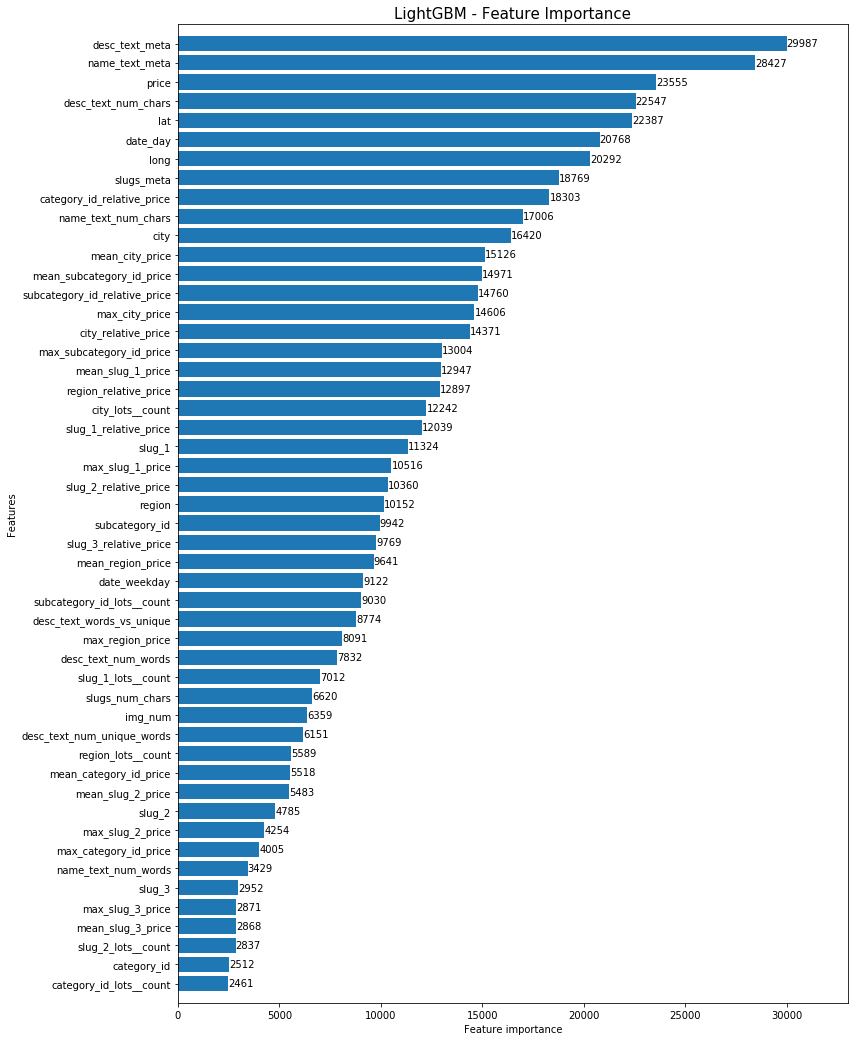

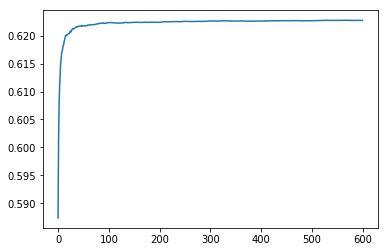

In [0]:
dev_X, val_X, dev_y, val_y = train_test_split(kek,train_y)

print(dev_X.shape, val_X.shape, test_X.shape)

# Training the model #
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, pokek)

fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

plt.plot(evals_result['valid_0']['auc'])

# Засылаем

0.014705882352941176
0.029411764705882353
0.04411764705882353
0.058823529411764705
0.07352941176470588
0.08823529411764706
0.10294117647058823
0.11764705882352941
0.1323529411764706
0.14705882352941177
0.16176470588235295
0.17647058823529413
0.19117647058823528
0.20588235294117646
0.22058823529411764
0.23529411764705882
0.25
0.2647058823529412
0.27941176470588236
0.29411764705882354


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.3088235294117647
0.3235294117647059
0.3382352941176471
0.35294117647058826
0.36764705882352944
0.38235294117647056
0.39705882352941174
0.4117647058823529
0.4264705882352941
0.4411764705882353
0.45588235294117646
0.47058823529411764
0.4852941176470588
0.5
0.5147058823529411
0.5294117647058824
0.5441176470588235
0.5588235294117647
0.5735294117647058
0.5882352941176471
0.6029411764705882
0.6176470588235294
0.6323529411764706
0.6470588235294118
0.6617647058823529
0.6764705882352942
0.6911764705882353
0.7058823529411765
0.7205882352941176
0.7352941176470589
0.75
0.7647058823529411
0.7794117647058824
0.7941176470588235
0.8088235294117647
0.8235294117647058
0.8382352941176471
0.8529411764705882
0.8676470588235294
0.8823529411764706
0.8970588235294118
0.9117647058823529
0.9264705882352942
0.9411764705882353
0.9558823529411765
0.9705882352941176
0.9852941176470589
1.0


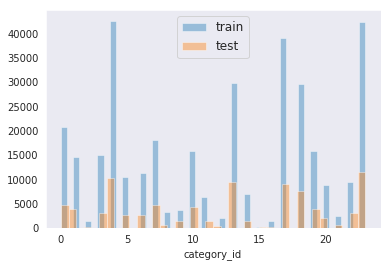

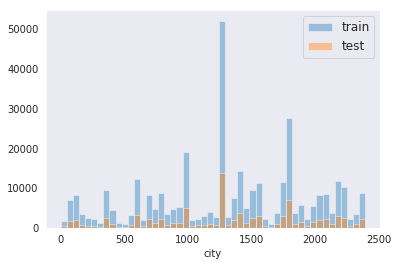

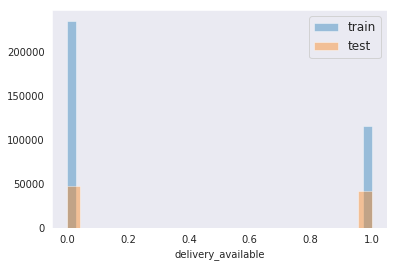

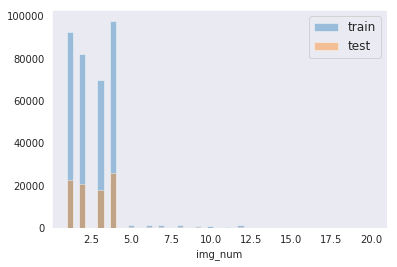

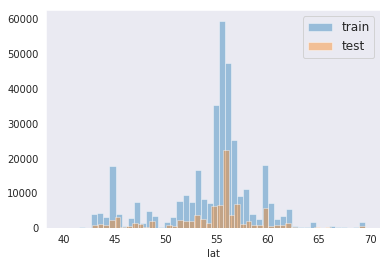

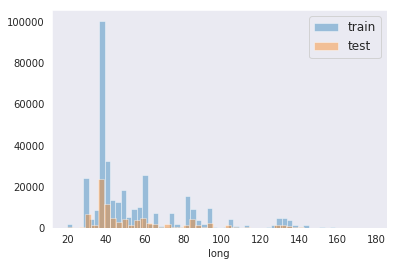

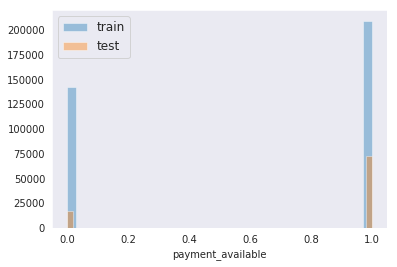

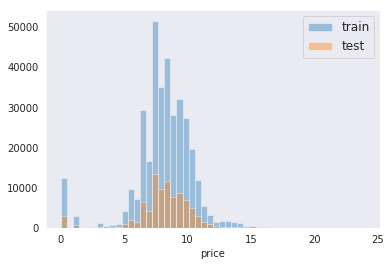

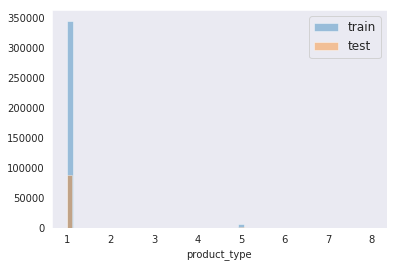

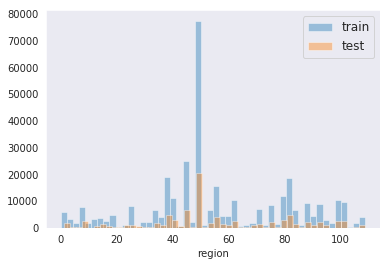

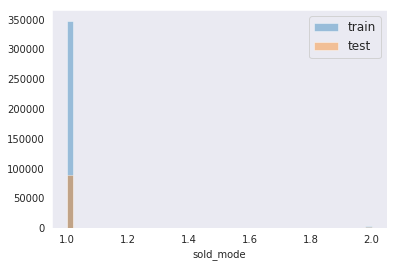

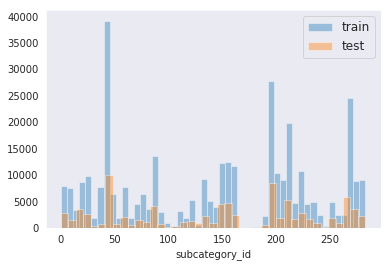

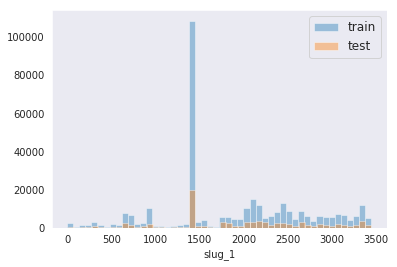

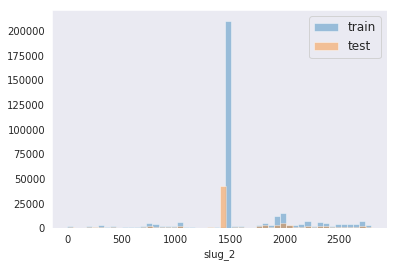

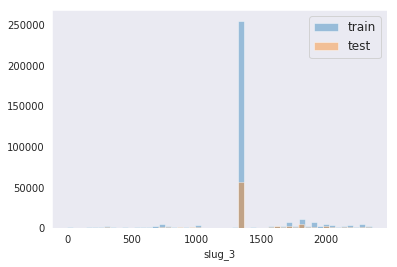

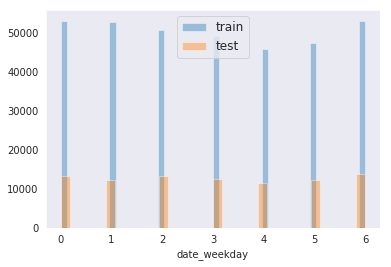

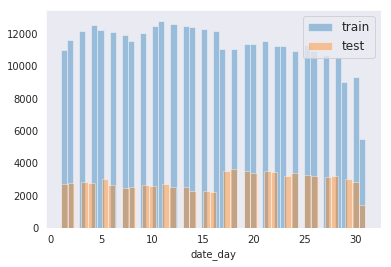

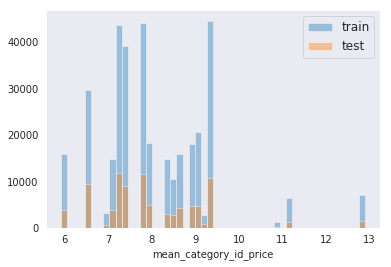

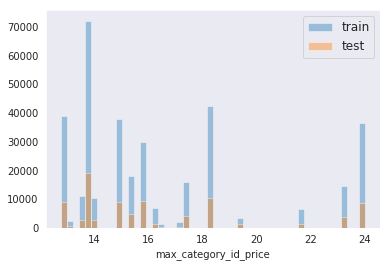

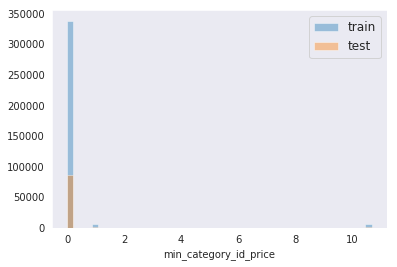

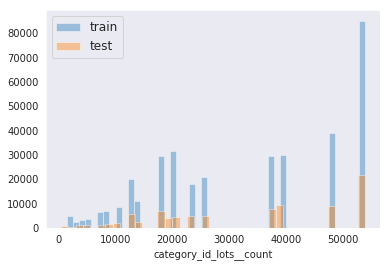

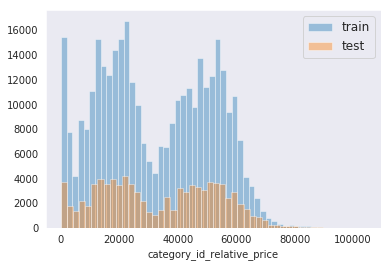

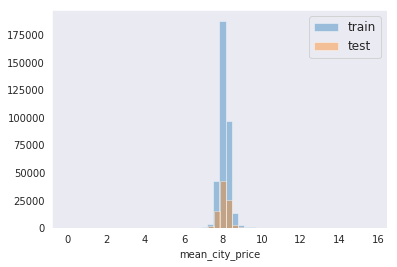

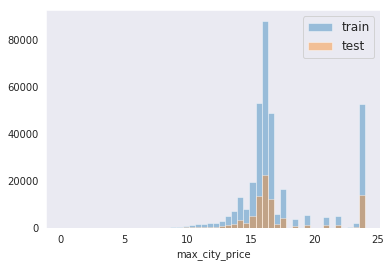

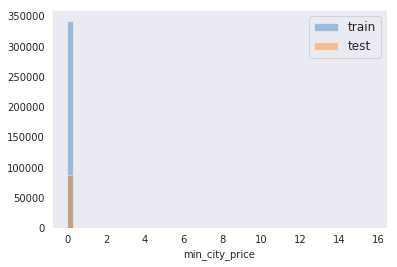

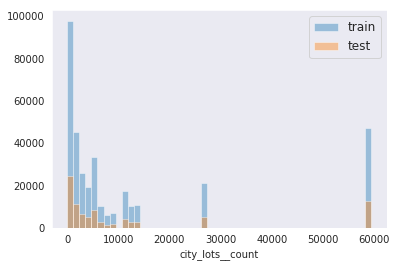

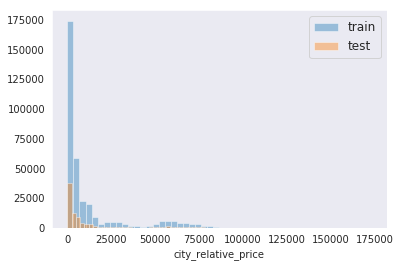

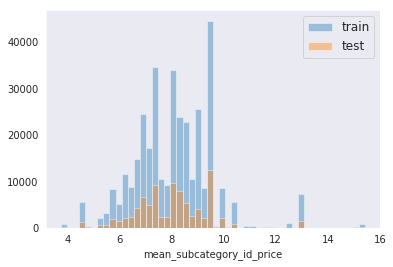

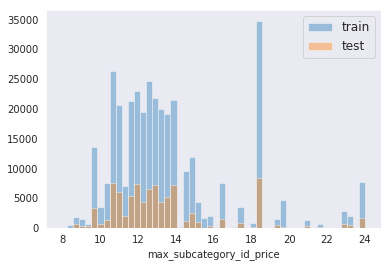

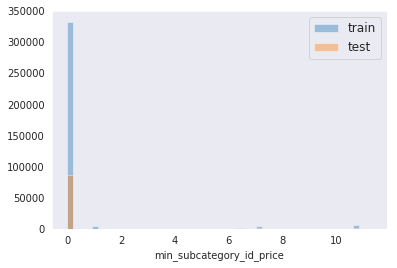

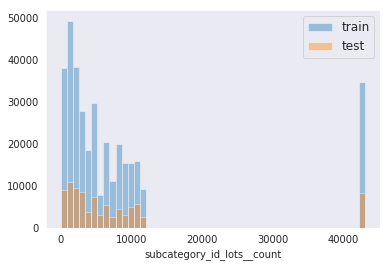

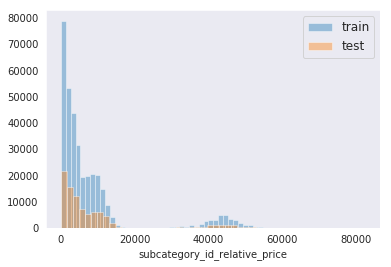

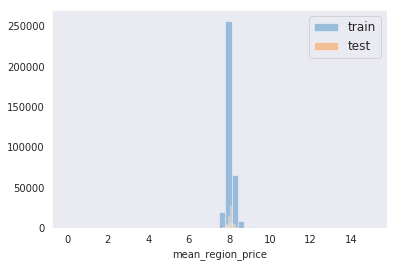

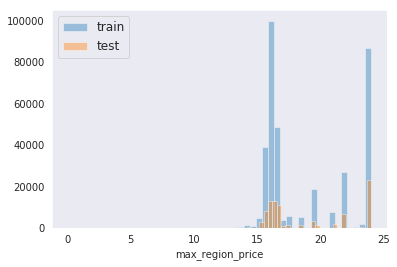

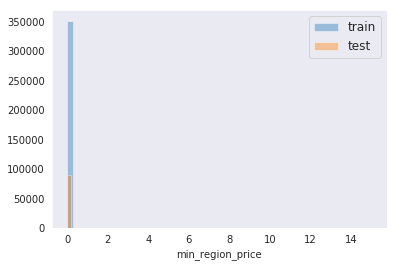

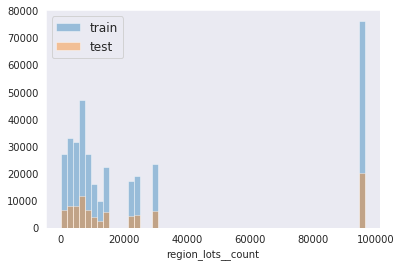

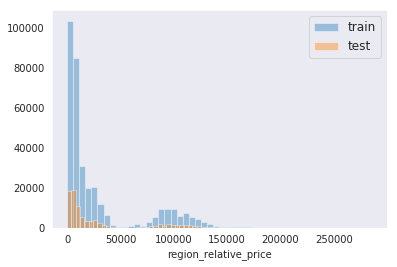

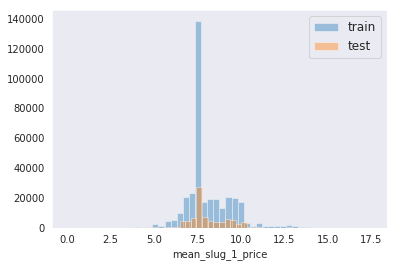

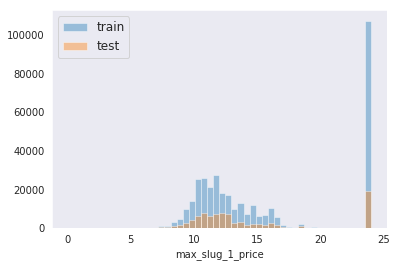

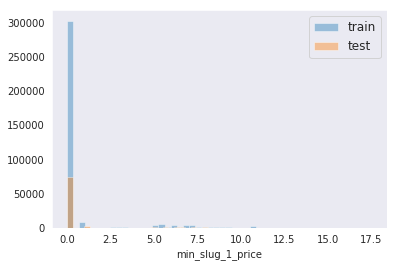

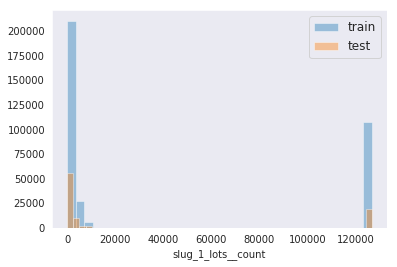

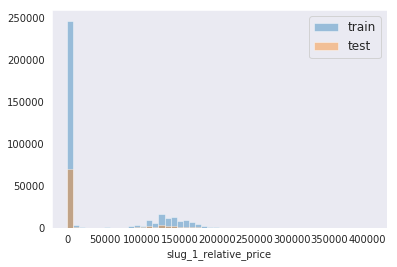

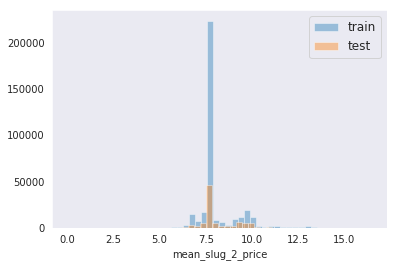

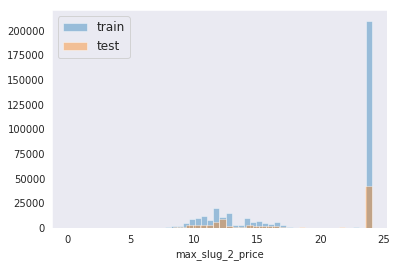

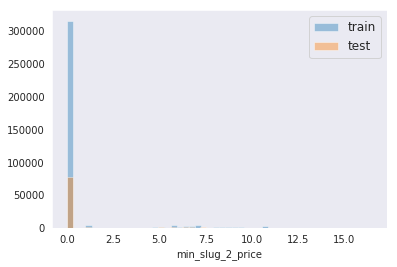

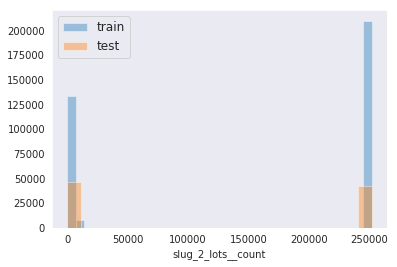

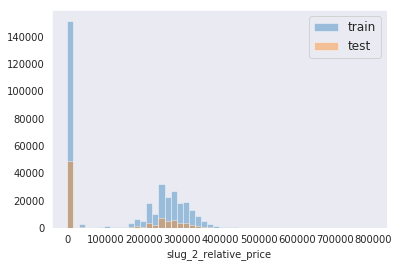

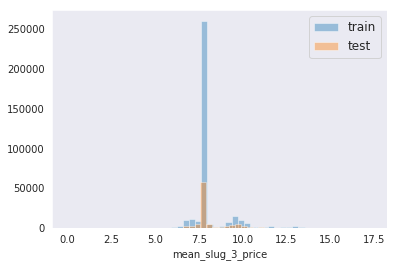

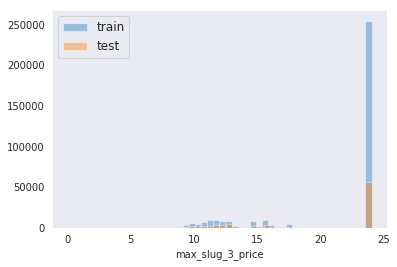

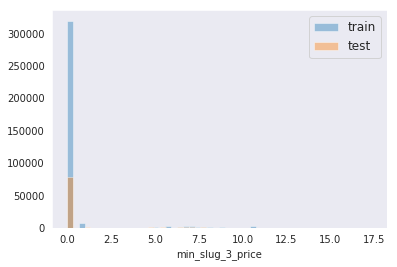

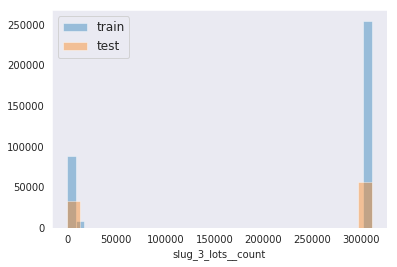

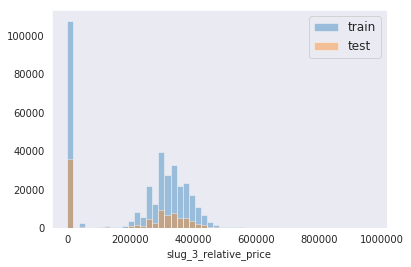

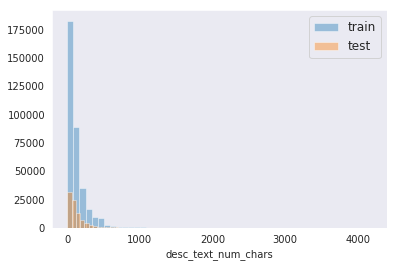

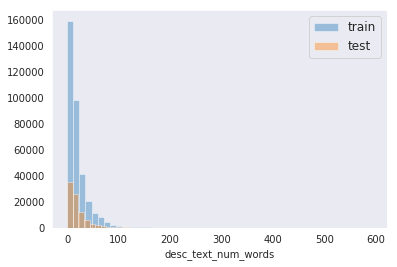

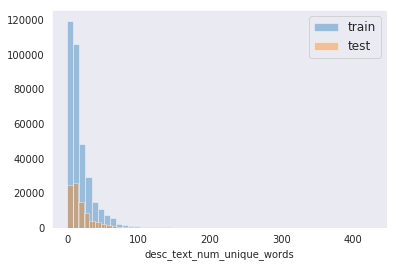

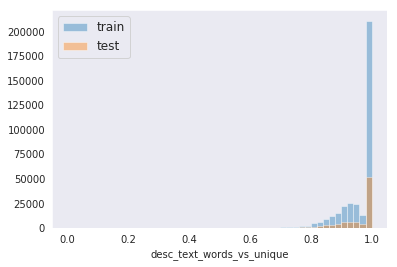

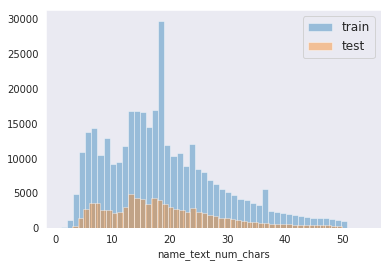

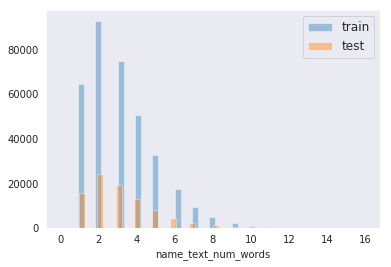

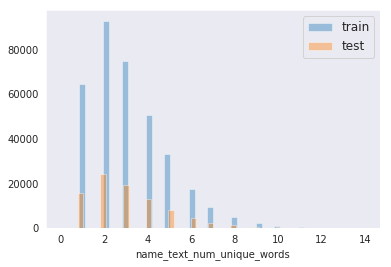

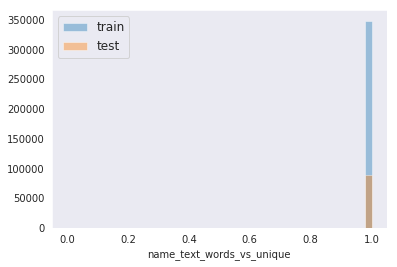

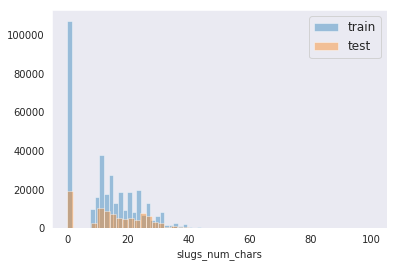

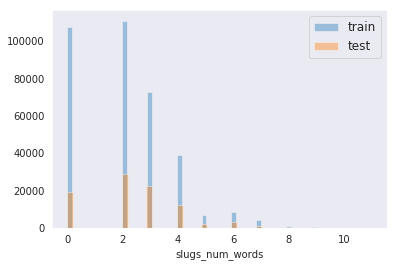

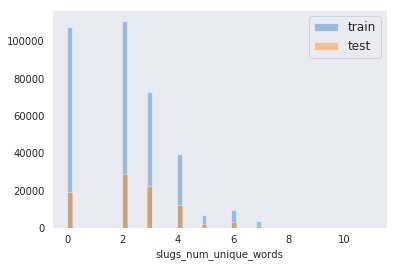

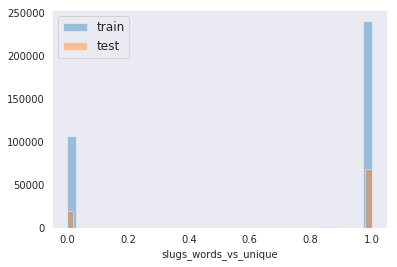

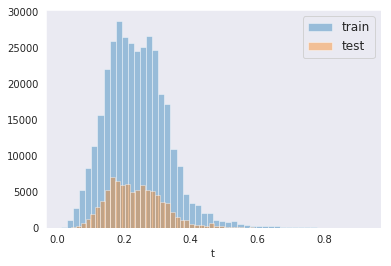

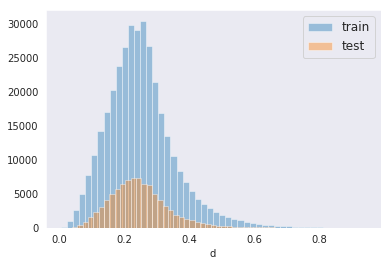

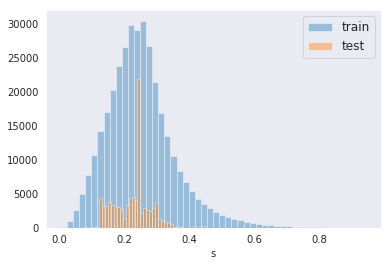

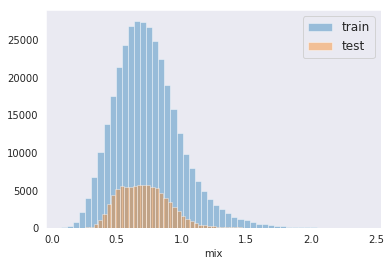

<Figure size 432x288 with 0 Axes>

In [0]:
import seaborn as sns

sns.set_style("dark")
i = 0
for col in kek.columns.values:
  i+=1
  print(i/len(kek.columns.values))
  ax = sns.distplot(kek[col],kde=False,label='train')
  sns.distplot(pokek[col],kde=False,label='test',ax=ax)
  plt.legend(prop={'size': 12})
  plt.figure()


In [0]:
from google.colab import files


subm = pd.DataFrame({"product_id":test_id,"score":pred_test})
subm.to_csv('subm_'+str(np.max(evals_result['valid_0']['auc']))+'.csv',index=False)
files.download('subm_'+str(np.max(evals_result['valid_0']['auc']))+'.csv') 
